In [2]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'medium',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

#line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

2023-01-19 05:33:49.015531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Plot efficiency w.r.t tau's pT (all training & testing data)

In [2]:
!ls ../models/

L1Tau_Jan_17_2023_mass.h5  L1Tau_v2_mass.h5  L1Tau_v3_corrected.h5
L1Tau_v1.h5		   L1Tau_v3_OG.h5    L1Tau_v4_EmSeed.h5


In [4]:
#Load the test indices
test_index = np.load("../ntuples/Jan_19_2023/index_test.npy")

sig = uproot4.open("../ntuples/Jan_19_2023/test_sig_v9_emseed.root")
tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]

#Load model and select out the tau
model = load_model('../models/L1Tau_v4_EmSeed.h5')

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index]

pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index]
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

#Selected out the tau pt with the basic cuts first
tau_pt_cut = tau_pt[selection_sig]

2023-01-19 05:32:20.078993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 05:32:20.084915: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
X_sig = np.asarray(sig_input[selection_sig])
y_sig = model.predict(X_sig)

273/273 [==============================] - 1s 4ms/step


In [6]:
nn_cut = y_sig.flatten() > 0.5

In [7]:
tau_pt_nn = np.asarray(tau_pt_cut)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[test_index][selection_sig])
tau_pt_old_nn = tau_pt_cut[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(tau_pt_cut)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 7976.0 (8158.0 with flow)

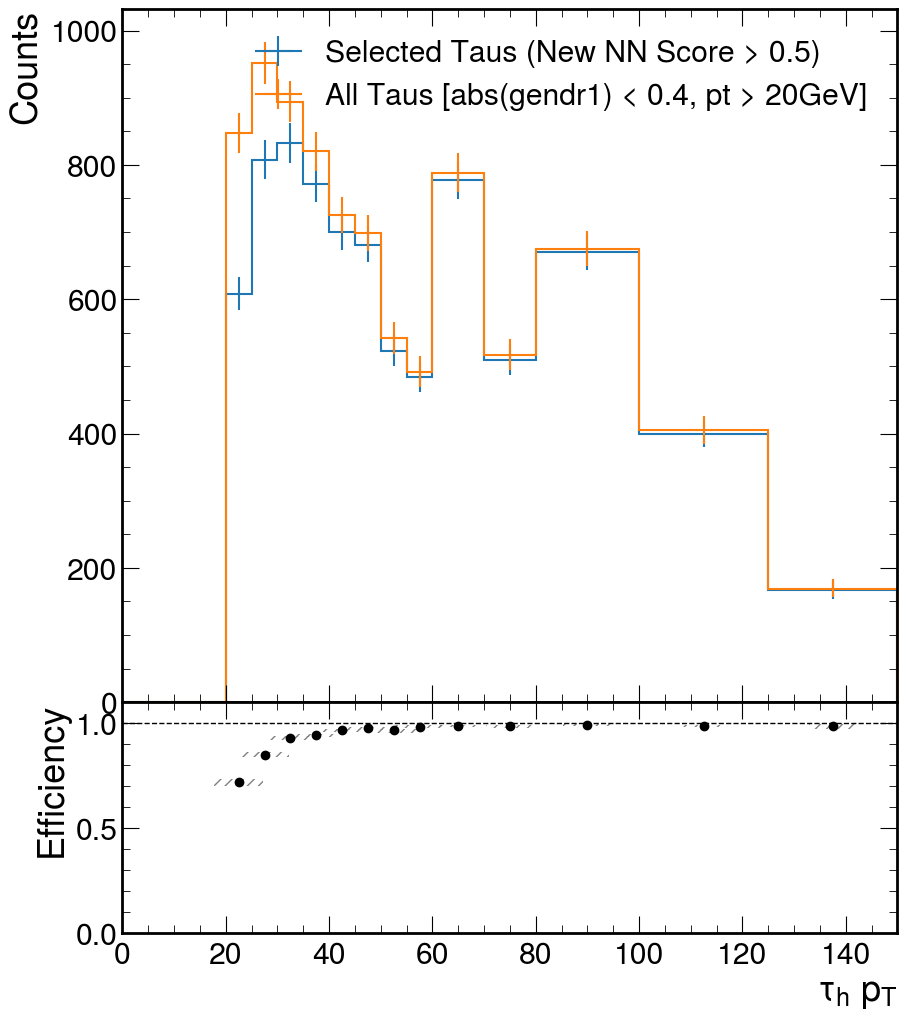

In [8]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (New NN Score > 0.5)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

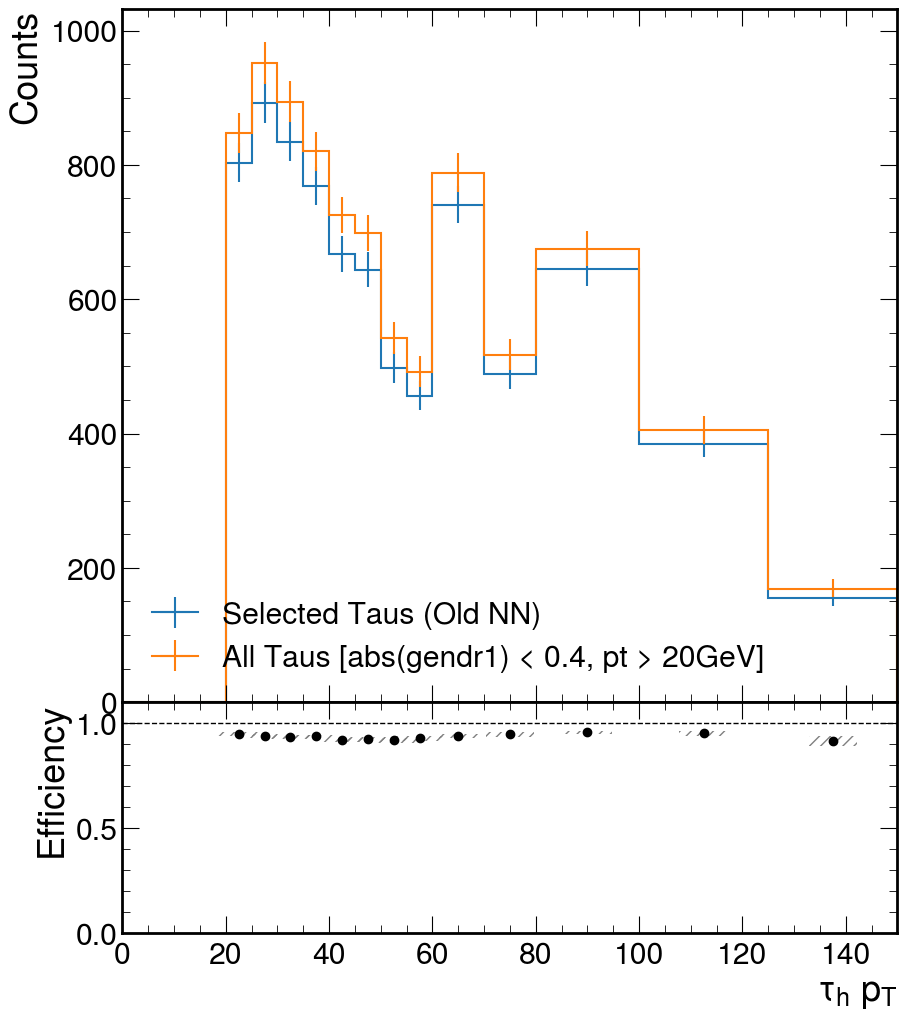

In [9]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

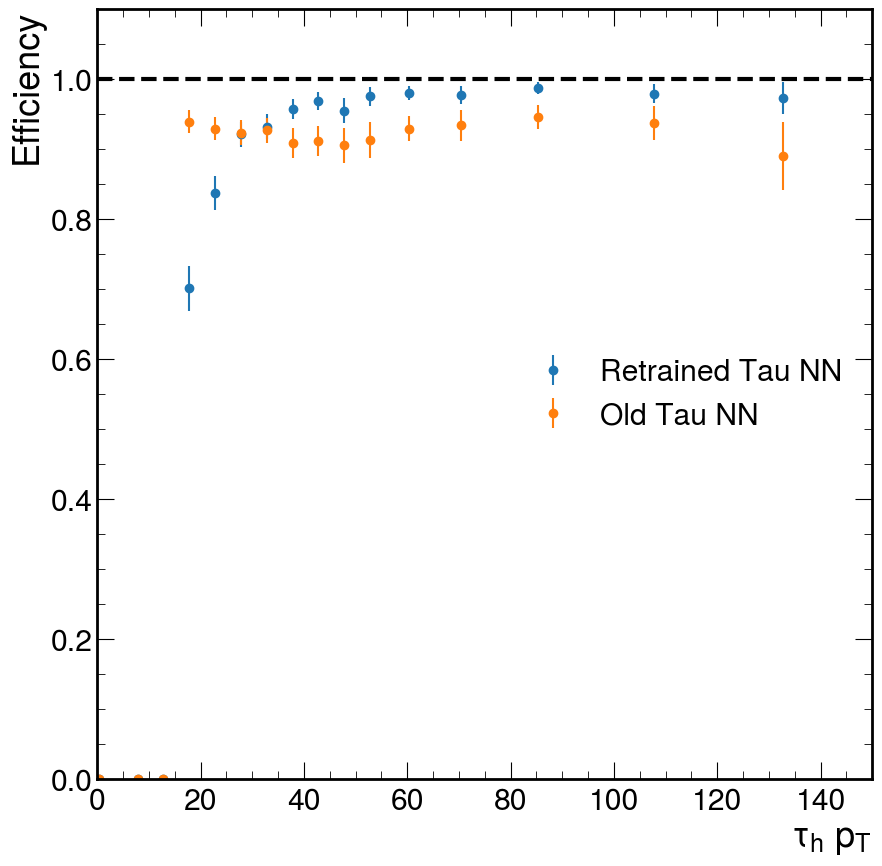

In [10]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
plt.xlabel(r"$\tau_h$ $p_T$")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

# Efficiency w.r.t $\eta$
Run this independently from the last part (i.e restart the kernel)

In [10]:
#Load the test indices
test_index = np.load("../ntuples/Jan_19_2023/index_test.npy")

sig = uproot4.open("../ntuples/Jan_19_2023/test_sig_v9_emseed.root")
tau_eta = sig['ntuplePupSingle']['tree']['eta'].array()[test_index]

#Load model and select out the tau
model = load_model('../models/L1Tau_v4_EmSeed.h5')

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index]

pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index]
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

#Selected out the tau pt with the basic cuts first
tau_eta_cut = tau_eta[selection_sig]

In [11]:
X_sig = np.asarray(sig_input[selection_sig])
y_sig = model.predict(X_sig)

273/273 [==============================] - 2s 8ms/step


In [12]:
nn_cut = y_sig.flatten() > 0.5

In [13]:
tau_eta_nn = np.asarray(tau_eta_cut)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[test_index][selection_sig])
tau_eta_old_nn = tau_eta_cut[old_tau_select == 1]

#Fill two plots and divide the two.
eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

hist_all_tau = Hist(eta_axis)
hist_selected_tau = Hist(eta_axis)
hist_selected_old_tau = Hist(eta_axis)

hist_all_tau.fill(tau_eta_cut)
hist_selected_tau.fill(tau_eta_nn)
hist_selected_old_tau.fill(tau_eta_old_nn)

Hist(Variable([-2.5, -2.3, -2, -1.8, -1.6, -1.4, -1, -0.6, -0.2, 0.2, 0.6, 1, 1.4, 1.6, 1.8, 2, 2.3, 2.5], name='$\\tau_h$ $\\eta$'), storage=Double()) # Sum: 8158.0

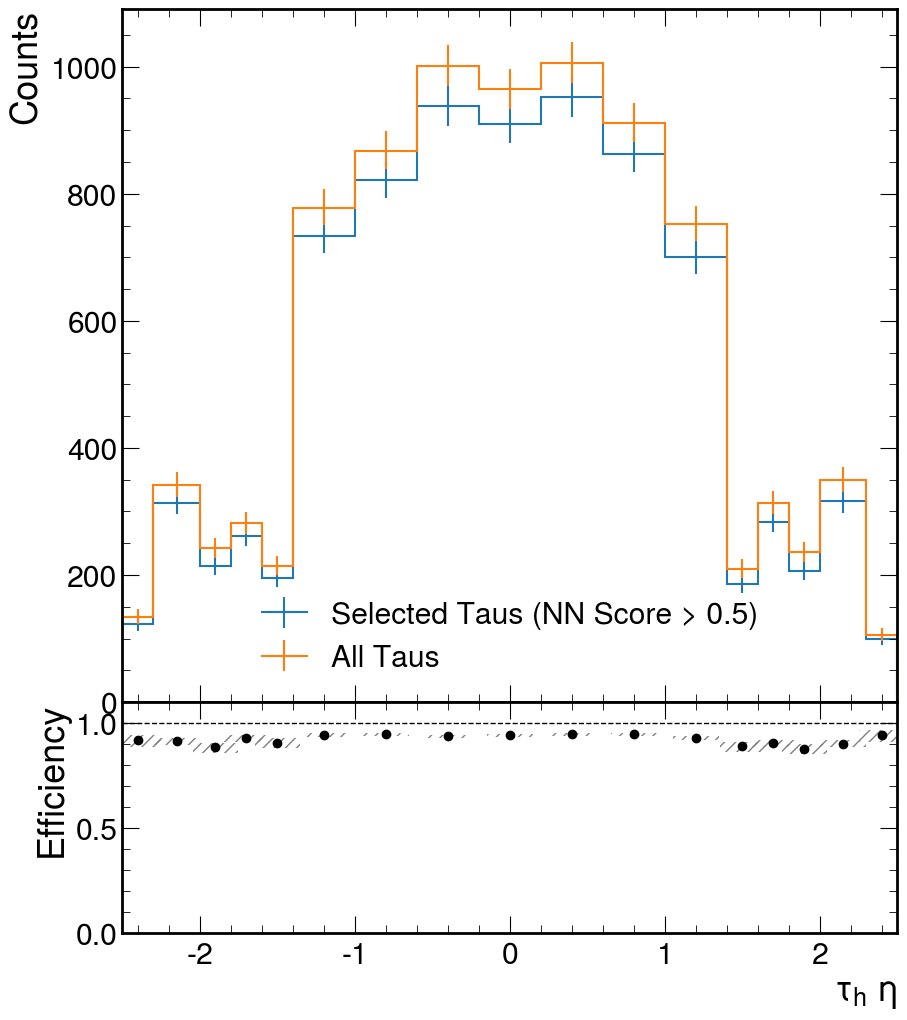

In [14]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

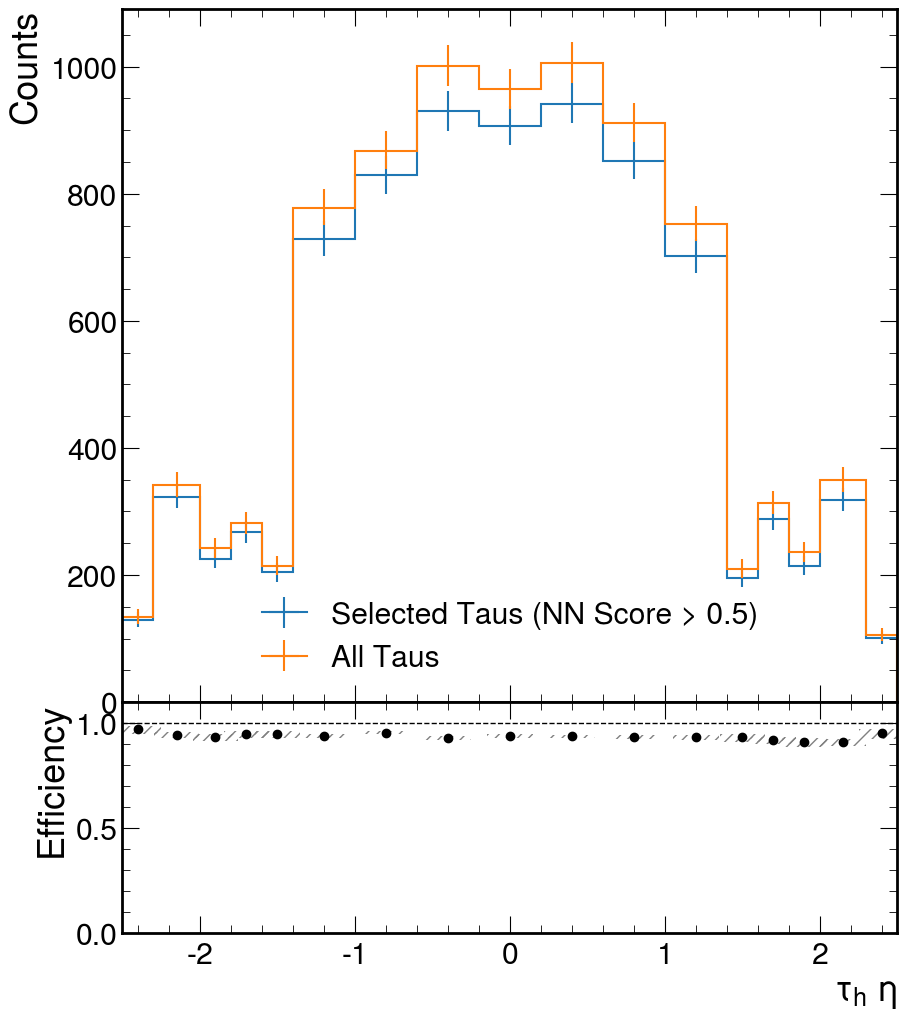

In [15]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

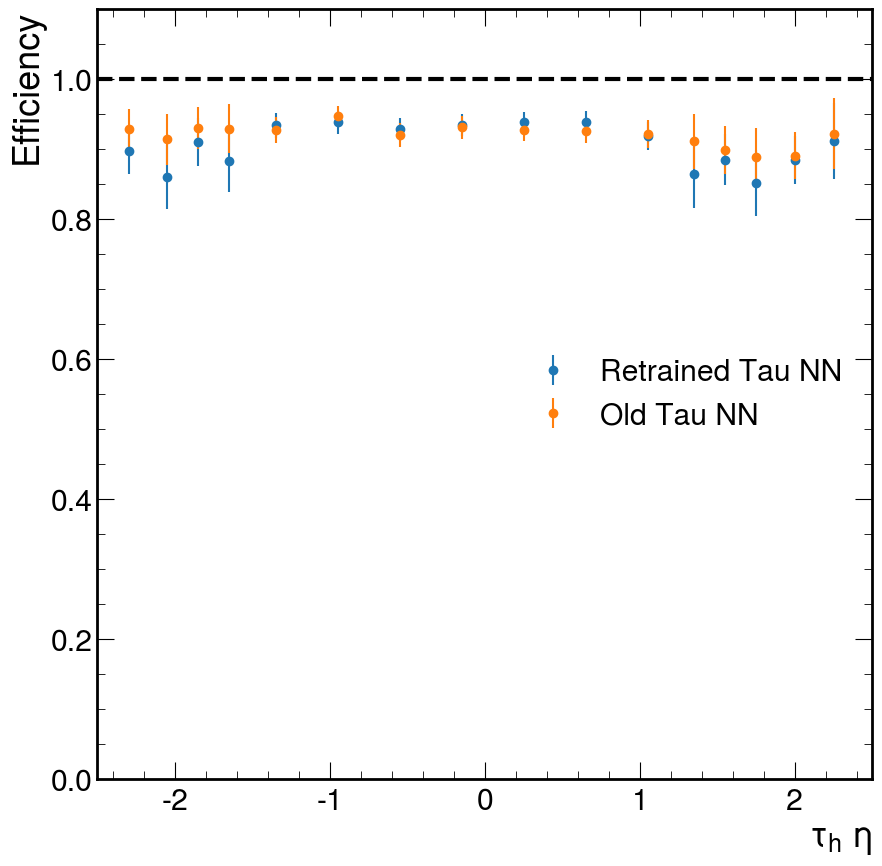

In [16]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, -2.5, 2.5, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([-2.5,2.5])
plt.xlabel(r"$\tau_h$ $\eta$")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()